# ConvFinQA
---
This notebook looks at both evaluation metrics:
---
- 1. **Answer match** - This is a new way to evaluate the answer score, thus differnt from '01_Answer_Eval.ipynb'
- 2. **Program_equivalence** - This follows the same methods used in '02_program_eval.ipynb'

---
### Metric: Answer Match 
----
- (i) **Previous Eval Methodology** - This is the final answer output of the model which tests for Accuracy: 'Exact match score'. This can be assessed using a pass(1) or fail (0).

- (ii) **New Eval Methodology** - This is the final answer output of the model which tests forAccuracy: 'Exact match score'. This can be assessed using values between 0-1. As such the metric will indicating their semantic similarity, where 0.0 means completely different and 1.0 means virtually identical.
---

### Providing Pydantic structure model outputs:

This was chosen as OpenAI mention that structured outputs are more suitable when you want to indicate a structured schema and recommend always using Structured Outputs when possible. The purpose of which was to further limit the scope of the outputs with the aim of getting to improve model performance. 


# 1. Load Data & Import Packages

In [143]:
from openai import OpenAI
import json
import os
import re
import random
import pandas as pd
from src.paths import DATA_DIR
from src.models import gpt_4o, gpt_4o_mini
import matplotlib.pyplot as plt
import scipy 

# Ensure dataframe has max with
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)

# Load the API key from environment variables
api_key = os.getenv("OPENAI_API_KEY")
openai = OpenAI(api_key=api_key)

# Training original data
with open(DATA_DIR / "train.json") as file:
    train_orig = json.load(file)

# 2. Load filtered data 

- "pre_text": the texts before the table;

- "post_text": the text after the table;

- "table": the table;

- "id": unique example id. composed by the original report name plus example
index for this report.

- "qa": {
  - "question": the question;

  - "program": the reasoning program;

  - "gold_inds": the gold supporting facts;

  - "exe_ans": the gold execution result;

  - "program_re": the reasoning program in nested format;
}

In [144]:
from src.preprocess import to_html
train_filtered = [
    {
        "id": "".join(file['id']),
        "pre_text": "".join(file["pre_text"]),
        "post_text": "".join(file["post_text"]),
        "html_table": to_html(file["table"]),
        "program": file['qa']['program'],
        "gold_inds": file['qa']['gold_inds'],
        "question": file["qa"]["question"],
        "gold_answer": file["qa"]["answer"],

    }

for file in train_orig
    # Must have 'qa' dict:
    if file.get("qa") is not None # The dictionary file must contain a "qa" key, and the value for "qa" cannot be None
    # 'answer' key must exist and not be blank:
       and file["qa"].get("answer") # Inside the "qa" dictionary, there must be a key "answer" that is not None
       and file["qa"]["answer"].strip() != "" # The "answer" string must not be blank or just whitespace.
    ]

In [145]:
# for i in range(len(train_filtered)):
#     print(train_filtered[i]['id'])
#     print(train_filtered[i]['gold_answer'])
#     print("-"*10)


In [146]:
train_filtered

[{'id': 'Single_JKHY/2009/page_28.pdf-3',
  'pre_text': '26 | 2009 annual report in fiscal 2008 , revenues in the credit union systems and services business segment increased 14% ( 14 % ) from fiscal 2007 .all revenue components within the segment experienced growth during fiscal 2008 .license revenue generated the largest dollar growth in revenue as episys ae , our flagship core processing system aimed at larger credit unions , experienced strong sales throughout the year .support and service revenue , which is the largest component of total revenues for the credit union segment , experienced 34 percent growth in eft support and 10 percent growth in in-house support .gross profit in this business segment increased $ 9344 in fiscal 2008 compared to fiscal 2007 , due primarily to the increase in license revenue , which carries the highest margins .liquidity and capital resources we have historically generated positive cash flow from operations and have generally used funds generated fro

In [147]:
# The IDs we want to match:
ids_to_find = {
    "Single_AMAT/2012/page_37.pdf-3",
    "Single_AAP/2006/page_85.pdf-3",
    "Single_GPN/2016/page_83.pdf-3"
}

# Filter the list
matched_records = [
    item for item in train_filtered
    if item.get("id") in ids_to_find
]

# Print or otherwise use the matched records
for rec in matched_records:
    print("ID:", rec["id"])
    print("Pre-text:", rec["pre_text"])
    print("Post-text:", rec["post_text"])
    print("Program", rec["program"])
    print("Table:", rec["html_table"])
    print("Gold_inds:", rec['gold_inds'])
    print("Question:", rec["question"])
    print("Gold_answer:", rec["gold_answer"])
    print("-" * 60)


ID: Single_GPN/2016/page_83.pdf-3
Pre-text: 2000 non-employee director stock option plan ( the 201cdirector stock option plan 201d ) , and the global payments inc .2011 incentive plan ( the 201c2011 plan 201d ) ( collectively , the 201cplans 201d ) .we made no further grants under the 2000 plan after the 2005 plan was effective , and the director stock option plan expired by its terms on february 1 , 2011 .we will make no future grants under the 2000 plan , the 2005 plan or the director stock option plan .the 2011 plan permits grants of equity to employees , officers , directors and consultants .a total of 14.0 million shares of our common stock was reserved and made available for issuance pursuant to awards granted under the 2011 plan .the following table summarizes share-based compensation expense and the related income tax benefit recognized for our share-based awards and stock options ( in thousands ) : 2016 2015 2014 ( in thousands ) .
Post-text: we grant various share-based award

# 4. Train, Dev, Test ( 100 samples each )

In [148]:
print("Total records:", len(train_filtered))
print(type(train_filtered))

# get a list of all id's
all_ids = []
for i in range(len(train_filtered)):
  all_ids.append(train_filtered[i]['id'])

# all_ids
num_total = len(all_ids)
num_unique = len(set(all_ids))

# Check they are all unique and therefore make it easy to split
print(num_total)
print(num_unique)

Total records: 2090
<class 'list'>
2090
2090


In [150]:
import random

# Ensure reproducibility
random.seed(42)  
random.shuffle(train_filtered)

n = len(train_filtered)
train_end = int(0.10 * n) 
dev_end = train_end + int(0.10 * n) 
test_end = dev_end + int(0.10 * n)  

# Assign data splits
train_data = train_filtered[:train_end]  
dev_data  = train_filtered[train_end:dev_end]  
test_data = train_filtered[dev_end: test_end]  

# Limiting size to 20 samples each for time
# train_data  = train_data[:100]
# dev_data = dev_data[:100]
# test_data = test_data[:100]


print("TRAIN records:", len(train_data))  
print("DEV records:",   len(dev_data))  
print("TEST records:",  len(test_data))  

print(type(train_data))  
print(type(train_data[0]))

TRAIN records: 209
DEV records: 209
TEST records: 209
<class 'list'>
<class 'dict'>


# 5.1 Create dataframe and model predictions 

In [151]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [152]:
from src.preprocess import process_records_struc_outputs
from src.answer_prompt.few_shot import V2_ANSWER_FEW_SHOT_PROMPT
from src.pydantic_class import StructuredResponse

# 1. 'process_records' creates the dataframe and columns 
train_df = process_records_struc_outputs(
    records=train_data,
    system_prompts=V2_ANSWER_FEW_SHOT_PROMPT,
    model_name=gpt_4o,
    prompt_style="Few-shot",
    table_key="html_table",  
    model_pred_col_name="model_answer", # new column being added from model predictions 
    StructuredResponse=StructuredResponse,
)

In [153]:
train_df.columns

Index(['id', 'pre_text', 'post_text', 'gold_answer', 'program', 'html_table', 'question', 'model', 'prompt_style', 'prompt', 'model_answer', 'model_program_prediction', 'model_reasoning'], dtype='object')

In [154]:
train_df[['question','program','model_program_prediction','gold_answer','model_answer','model_reasoning']].head(2)

question                                           program                   model_program_prediction gold_answer model_answer                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           model_reasoning
0  what percentage of consumer packaging sales where from north american consumer packaging in 2015?       multiply(1.9, const_1000), divide(#0, 2940)      divide(1900, 2940), multiply(#0, 100)         65%        64.6%                                                    To find the percentage of consumer packaging sales that were from North American consumer packaging in 2015, we need to divide the North American consumer packaging sales by the total consumer packaging sales and then multiply by 100 to convert the result to a percentage. From the text, North American consumer packaging net sales were $1.9 billion in 2015. From the table, the total consumer packaging sales were $2.940 billion in 2015. Therefore, the percentage would be (1.9 / 2.940) * 100 = 64.6%.
1                     what is the approximate customer penetration in the west virginia market area?  multiply(0.6, const_1000000), divide(169037, #0)  divide(169037, 600000), multiply(#0, 100)         28%        28.2%  To calculate customer penetration, we need to divide the number of customers by the estimated population served and multiply by 100 to convert it to percentage. In West Virginia, the number of customers is 169,037, and the estimated population served is 600,000 (since they serve 0.6 million). Performing these operations, we get a customer penetration of (169037 / 600000) * 100 ≈ 28.2%. Therefore, the approximate customer penetration in the West Virginia market area is 28.2%. This calculation uses the given data within the table for West Virginia.

## 5.2 Add Eval for answer_match_score 

In [155]:
from src.LLM_as_judge.answer import EVAL_ANSWER_PROMPT 
from src.preprocess import add_llm_explanation_column_new

train_df = add_llm_explanation_column_new(
    df=train_df,
   system_prompt_template= EVAL_ANSWER_PROMPT,
    model_name=gpt_4o,
    gold_col="gold_answer",
    pred_col="model_answer",
    new_col_name="answer_match_score"
)

In [156]:
train_df[['question','program','model_program_prediction','gold_answer','model_answer','answer_match_score', 'model_reasoning']].head(2)

question                                           program                   model_program_prediction gold_answer model_answer answer_match_score                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           model_reasoning
0  what percentage of consumer packaging sales where from north american consumer packaging in 2015?       multiply(1.9, const_1000), divide(#0, 2940)      divide(1900, 2940), multiply(#0, 100)         65%        64.6%               0.95                                                    To find the percentage of consumer packaging sales that were from North American consumer packaging in 2015, we need to divide the North American consumer packaging sales by the total consumer packaging sales and then multiply by 100 to convert the result to a percentage. From the text, North American consumer packaging net sales were $1.9 billion in 2015. From the table, the total consumer packaging sales were $2.940 billion in 2015. Therefore, the percentage would be (1.9 / 2.940) * 100 = 64.6%.
1                     what is the approximate customer penetration in the west virginia market area?  multiply(0.6, const_1000000), divide(169037, #0)  divide(169037, 600000), multiply(#0, 100)         28%        28.2%               0.95  To calculate customer penetration, we need to divide the number of customers by the estimated population served and multiply by 100 to convert it to percentage. In West Virginia, the number of customers is 169,037, and the estimated population served is 600,000 (since they serve 0.6 million). Performing these operations, we get a customer penetration of (169037 / 600000) * 100 ≈ 28.2%. Therefore, the approximate customer penetration in the West Virginia market area is 28.2%. This calculation uses the given data within the table for West Virginia.

# 5.3 Add Eval for program_equivalence

In [157]:
from src.program_prompt.model_eval import PROGRAM_EVALUATION_PROMPT

train_df = add_llm_explanation_column_new(
    df=train_df,
   system_prompt_template=PROGRAM_EVALUATION_PROMPT,
    model_name=gpt_4o,
    gold_col="program",
    pred_col="model_program_prediction",
    new_col_name="program_equivalence"
)

In [160]:
train_df[['question','program','model_program_prediction',"program_equivalence",'gold_answer','model_answer',"answer_match_score",'model_reasoning']].head(2)

question                                           program                   model_program_prediction program_equivalence gold_answer model_answer answer_match_score                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           model_reasoning
0  what percentage of consumer packaging sales where from north american consumer packaging in 2015?       multiply(1.9, const_1000), divide(#0, 2940)      divide(1900, 2940), multiply(#0, 100)                   0         65%        64.6%               0.95                                                    To find the percentage of consumer packaging sales that were from North American consumer packaging in 2015, we need to divide the North American consumer packaging sales by the total consumer packaging sales and then multiply by 100 to convert the result to a percentage. From the text, North American consumer packaging net sales were $1.9 billion in 2015. From the table, the total consumer packaging sales were $2.940 billion in 2015. Therefore, the percentage would be (1.9 / 2.940) * 100 = 64.6%.
1                     what is the approximate customer penetration in the west virginia market area?  multiply(0.6, const_1000000), divide(169037, #0)  divide(169037, 600000), multiply(#0, 100)                   0         28%        28.2%               0.95  To calculate customer penetration, we need to divide the number of customers by the estimated population served and multiply by 100 to convert it to percentage. In West Virginia, the number of customers is 169,037, and the estimated population served is 600,000 (since they serve 0.6 million). Performing these operations, we get a customer penetration of (169037 / 600000) * 100 ≈ 28.2%. Therefore, the approximate customer penetration in the West Virginia market area is 28.2%. This calculation uses the given data within the table for West Virginia.

# 6. Results:


# 6.1 Results for Exact_match: 
---

Metric now evaluate between 0-1 

## Threshold >= 0.95 = 49.7%,

## Threshold of >= 0.99 = 24.4%

## With a threshold of >= 0.99, it is a +4.21% increase, with the threshold of >=0.95 it is a +28.91% increase (when compared to previos best results)

---
- The Interquartile range (IQR - majority of answer_match_score values) ...

- Some data points are significantly lower, around 0–0.3, pulling the mean to 0.74. 

- The median is 0.94, showcasing the model is indeded performing well at a higher level view, however under more scrutiny the errors being made still continue to look like rounding errors, but this level of accuracy matters given this context.


 


In [161]:
train_df['answer_match_score'] = pd.to_numeric(train_df['answer_match_score'], errors='coerce')
print(train_df['answer_match_score'].describe())

count    209.000000
mean       0.742383
std        0.366346
min        0.000000
25%        0.700000
50%        0.940000
75%        0.980000
max        1.000000
Name: answer_match_score, dtype: float64


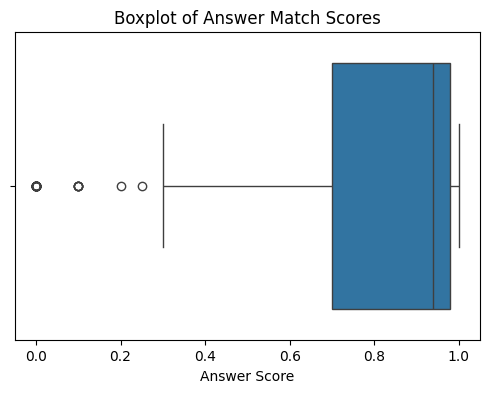

In [162]:
import seaborn as sns

plt.figure(figsize=(6,4))
sns.boxplot(x='answer_match_score', data=train_df)
plt.title("Boxplot of Answer Match Scores")
plt.xlabel("Answer Score")
plt.show()

# 6.2 Threshold based analysis


In [169]:
# Set very high given task requirements
train_df_copy = train_df.copy()
threshold = 0.99
above_thresh = (train_df_copy['answer_match_score'] >= threshold).sum()
total = len(train_df_copy)
print(f"{above_thresh} out of {total} are >= {threshold}")

51 out of 209 are >= 0.99


In [170]:
# Filter the dataframe
filtered_df = train_df_copy[train_df_copy['answer_match_score'] > threshold]

# Display the filtered dataframe
import ace_tools_open as tools
tools.display_dataframe_to_user(name="Filtered Data", 
                                dataframe=filtered_df[['question','gold_answer','model_answer',"answer_match_score"]])

Filtered Data



# 6.3 Results for Program Equivalence: 17.07%

## Basic Prompting on previous results: (37.98%)

- As such, the previous prompt was shown to be better than the current one used here.I believe the prompting and description provided in the pydantic field class may be influencing this.

In [165]:
# 3. Eval at aggreate level to see performance
from src.evals import exact_match_score_numeric
print(exact_match_score_numeric(train_df, "program_equivalence"))
train_df[['question','program','model_program_prediction',"program_equivalence",'gold_answer','model_answer',"answer_match_score",'model_reasoning',]].head(2)

Accuracy Score: 35.0/205 (17.07%)


question                                           program                   model_program_prediction  program_equivalence gold_answer model_answer  answer_match_score                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           model_reasoning
0  what percentage of consumer packaging sales where from north american consumer packaging in 2015?       multiply(1.9, const_1000), divide(#0, 2940)      divide(1900, 2940), multiply(#0, 100)                  0.0         65%        64.6%                0.95                                                    To find the percentage of consumer packaging sales that were from North American consumer packaging in 2015, we need to divide the North American consumer packaging sales by the total consumer packaging sales and then multiply by 100 to convert the result to a percentage. From the text, North American consumer packaging net sales were $1.9 billion in 2015. From the table, the total consumer packaging sales were $2.940 billion in 2015. Therefore, the percentage would be (1.9 / 2.940) * 100 = 64.6%.
1                     what is the approximate customer penetration in the west virginia market area?  multiply(0.6, const_1000000), divide(169037, #0)  divide(169037, 600000), multiply(#0, 100)                  0.0         28%        28.2%                0.95  To calculate customer penetration, we need to divide the number of customers by the estimated population served and multiply by 100 to convert it to percentage. In West Virginia, the number of customers is 169,037, and the estimated population served is 600,000 (since they serve 0.6 million). Performing these operations, we get a customer penetration of (169037 / 600000) * 100 ≈ 28.2%. Therefore, the approximate customer penetration in the West Virginia market area is 28.2%. This calculation uses the given data within the table for West Virginia.

# 7. Dev set testing - I'm not able to get the model to perform well enough on the train set to start testing on dev. 

- Once I get training set to perform better I would, then start testin against dev, make futher adaptations based on error analysis, perhaps different pre-processing and other prompt engineering techniques. 
- Once the llm is performing well on the dev set I would finally test on test set 

# Recommendations 

- This would involve working with the business to determine accectable threshold levels 
- Prompt engineering - Perhaps ReAct and / or providing a reasoning model as a param 
- Try with a reasoning model e.g. 03-mini 
- Fine-tuning 

# Save train_df as csv

In [142]:
# train_df.to_csv("answer_and_prog_eval.csv", index=False)

